<a href="https://colab.research.google.com/github/dkisselev-zz/mmc-pipeline/blob/main/PubMed_Journals_by_Year.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NCBI Journal Publication Counter

This notebook uses the NCBI E-utilities API to search for a specific term over a range of years. It then counts the number of publications for each journal and presents the results in a table.

Features:

* Uses your NCBI API key for a higher request rate.
* Includes robust retry logic to handle network or API errors.
* Fetches data in batches to handle large result sets efficiently.
* Presents the final data in an easy-to-read, pivotable format using Pandas.

## Setup

In [ ]:
import time
import os
import re
import requests
import json
from collections import Counter
import calendar
import numpy as np
import pandas as pd
from scipy.stats import chisquare
import xml.etree.ElementTree as ET
from tqdm.notebook import tqdm

from google.colab import userdata
from google.colab import auth
from google.colab.data_table import DataTable
from google.auth import default
import gspread

print("Libraries imported successfully!")

Libraries imported successfully!


## ⚙️ Configuration

IMPORTANT: You must fill in the variables in the cell below.

* SEARCH_TERM: The topic you want to search for (e.g., "crispr", "autism", "mitochondria").
* START_YEAR and END_YEAR: The range of publication years to analyze.
* YOUR_EMAIL or API_KEY: Provide your email and an NCBI API key as colab Secrets

In [ ]:
search_term = "microbiome" # @param {"type":"string","placeholder":"The topic you want to search for (e.g., \"microbiome\")"}
start_year = 2005 # @param {"type":"integer"}
end_year = 2025 # @param {"type":"integer"}
api_access = True # @param {"type":"boolean","placeholder":"Do you have NCBI API Key"}


In [ ]:
# 1. Set your search term
SEARCH_TERM = search_term

# 2. Set the year range (inclusive)
START_YEAR = start_year
END_YEAR = end_year

# 3. Enter your email or NCBI API key
# Get your API key here: https://ncbi.nlm.nih.gov/account/settings/
API_KEY = userdata.get('NCBI_API_KEY')
YOUR_EMAIL = userdata.get('EMAIL')

# --- SCRIPT SETTINGS ---
BASE_URL = "https://eutils.ncbi.nlm.nih.gov/entrez/eutils/"
RETRIES = 3
RETRY_DELAY = 5 # seconds
FETCH_BATCH_SIZE = 500
MAX_UIDS = 9900 # A safe limit below the 9,999 max
FETCH_ID_BATCH_SIZE = 400 # Number of IDs to fetch in one EFetch POST request

# CrossRef Config (New)
CROSSREF_BASE_URL = "https://api.crossref.org/works/"
CROSSREF_RETRIES = 3
CROSSREF_RETRY_DELAY = 1 # seconds
USER_AGENT = f"Mozilla/5.0 (compatible; Google Colab/1.0; +{YOUR_EMAIL})"


# Basic validation
if (api_access and API_KEY=="") or (not api_access and YOUR_EMAIL == "") or SEARCH_TERM == "":
    print("⚠️ PLEASE UPDATE the SEARCH_TERM, YOUR_EMAIL variables before running!")
if int(START_YEAR) > int(END_YEAR):
    print("⚠️ Start year can't be bigger than end year!")

## API Helper Functions

These functions handle the communication with the NCBI API. They include logic for retries, batching, and parsing the XML responses.

In [ ]:
def get_all_unique_pmids(term, year, api_key):
    """
    Collects all unique PubMed IDs (PMIDs) for a search term in a given year.
    Handles batching by month if the result set is too large.
    """
    unique_pmids = set()
    date_queries = []

    # First, check the total count for the year to decide on a strategy
    print(f"Checking total results for {year}...")
    initial_params = {'db': 'pubmed', 'term': f'(({term}) NOT (review[pt]) AND ("{year}"[pdat])', 'rettype': 'count'}
    if api_key:
        initial_params['api_key'] = api_key
    else:
        initial_params['email'] = YOUR_EMAIL

    response = make_api_request(f"{BASE_URL}esearch.fcgi", initial_params)
    total_count = int(ET.fromstring(response.text).findtext('Count', '0')) if response else 0
    print(f"Found approximately {total_count} articles for {year}.")

    # If count is too high, prepare monthly queries. Otherwise, use a single yearly query.
    if total_count > MAX_UIDS:
        print(f"⚠️ Result count exceeds {MAX_UIDS}. Preparing to query month-by-month.")
        for month in range(1, 13):
            days_in_month = calendar.monthrange(year, month)[1]
            date_queries.append(f'("{year}/{month:02d}/01"[pdat] : "{year}/{month:02d}/{days_in_month:02d}"[pdat])')
    else:
        date_queries.append(f'("{year}"[pdat])')

    # Execute the queries and collect all PMIDs into a set for automatic deduplication
    for date_query in tqdm(date_queries, desc=f"Collecting PMIDs for {year}"):
        params = {
            'db': 'pubmed', 'term': f'({term}) AND {date_query}',
            'retmax': MAX_UIDS, 'usehistory': 'n', 'retmode': 'xml',
            'tool': 'colab_notebook',
        }
        if api_key:
            params['api_key'] = api_key
        else:
            params['email'] = YOUR_EMAIL
        response = make_api_request(f"{BASE_URL}esearch.fcgi", params)
        if response:
            root = ET.fromstring(response.text)
            pmids_in_batch = {id_node.text for id_node in root.findall('.//IdList/Id')}
            unique_pmids.update(pmids_in_batch)
        time.sleep(0.2)

    return unique_pmids

def fetch_and_process_details(pmids, api_key):
    """
    Fetches details for a list of PMIDs and extracts journal and publication year.
    Uses POST requests to handle large numbers of IDs efficiently.
    """
    if not pmids:
        return Counter()

    journal_counts_by_year = Counter()
    pmid_list = list(pmids) # Convert set to list for slicing

    pbar = tqdm(range(0, len(pmid_list), FETCH_ID_BATCH_SIZE), desc="Fetching article details")
    for i in pbar:
        batch = pmid_list[i:i + FETCH_ID_BATCH_SIZE]

        # EFetch is more efficient with POST for large ID lists
        params = {
            'db': 'pubmed', 'rettype': 'abstract', 'retmode': 'xml',
            'tool': 'colab_notebook'
        }
        if api_key:
            params['api_key'] = api_key
        else:
            params['email'] = YOUR_EMAIL

        files = {'id': ",".join(batch)}

        response = make_api_request_post(f"{BASE_URL}efetch.fcgi", params, files)

        if response:
            root = ET.fromstring(response.text)
            for article in root.findall('.//PubmedArticle'):
                # Extract the actual publication year and journal title from the record
                year_node = article.find('.//PubDate/Year')
                journal_node = article.find('.//Journal/Title')
                pmid_node = article.find('.//PMID')
                issn_node = article.find('.//Journal/ISSN')
                doi_node = article.find('.//ArticleIdList/ArticleId[@IdType="doi"]')

                # pub_year = int(year_node.text.strip()) if year_node is not None and year_node.text else None
                # journal_title = journal_node.text.strip() if journal_node is not None and journal_node.text else None
                # pmid = pmid_node.text.strip() if pmid_node is not None and pmid_node.text else None
                # issn = issn_node.text.strip() if issn_node is not None and issn_node.text else None
                # doi = doi_node.text.strip() if doi_node is not None and doi_node.text else None

                if year_node is not None and journal_node is not None and year_node.text and journal_node.text:
                    try:
                        pub_year = int(year_node.text.strip())
                        journal_title = journal_node.text.strip()
                        journal_counts_by_year[(pub_year, journal_title)] += 1
                    except (ValueError, TypeError):
                        continue

        time.sleep(0.2)

    return journal_counts_by_year

# You also need a new helper function for POST requests
def make_api_request_post(url, params, files):
    """Makes a POST request to the NCBI API with retry logic."""
    for attempt in range(RETRIES):
        try:
            response = requests.post(url, params=params, files=files, timeout=30)
            response.raise_for_status()
            return response
        except requests.exceptions.RequestException as e:
            print(f"POST request failed (attempt {attempt + 1}/{RETRIES}): {e}")
            if attempt < RETRIES - 1:
                print(f"Retrying in {RETRY_DELAY} seconds...")
                time.sleep(RETRY_DELAY)
            else:
                print("Max retries reached for POST request. Moving on.")
                return None

def make_api_request(url, params):
    """Makes a request to the NCBI API with retry logic."""
    for attempt in range(RETRIES):
        try:
            response = requests.get(url, params=params, timeout=20)
            response.raise_for_status()  # Raises an HTTPError for bad responses (4XX or 5XX)
            return response
        except requests.exceptions.RequestException as e:
            print(f"Request failed (attempt {attempt + 1}/{RETRIES}): {e}")
            if attempt < RETRIES - 1:
                print(f"Retrying in {RETRY_DELAY} seconds...")
                time.sleep(RETRY_DELAY)
            else:
                print("Max retries reached. Moving on.")
                return None

def standardize_journal_name(name):
    """Basic standardization for journal names."""
    if pd.isna(name):
        return None
    name = str(name).lower().strip()
    name = re.sub(r'[^\w\s]', '', name)
    name = re.sub(r'\s+', ' ', name)
    return name

## Main Execution

This is the main loop that iterates through your specified year range, calls the API functions, and collects all the data.

In [ ]:
all_results = []

print(f"Starting analysis for term '{SEARCH_TERM}' from {START_YEAR} to {END_YEAR}...")

for year in range(START_YEAR, END_YEAR + 1):
    print(f"\n--- Processing Year: {year} ---")

    # Step 1: Get all unique article IDs for the year, automatically handling batching.
    unique_pmids = get_all_unique_pmids(SEARCH_TERM, year, API_KEY)

    if not unique_pmids:
        print(f"No unique articles found for {year}.")
        continue

    print(f"Found {len(unique_pmids)} unique articles for {year}.")

    # Step 2: Fetch details for the unique IDs and get counts of (Year, Journal)
    journal_counts = fetch_and_process_details(unique_pmids, API_KEY)

    # Step 3: Store the aggregated results
    for (pub_year, journal), count in journal_counts.items():
        all_results.append({
            'Year': pub_year,
            'Journal': journal,
            'Count': count
        })

print("\n✅ Analysis complete!")

Starting analysis for term 'microbiome' from 2005 to 2025...

--- Processing Year: 2005 ---
Checking total results for 2005...
Found approximately 214 articles for 2005.


Found 261 unique articles for 2005.


Fetching article details:   0%|          | 0/1 [00:00<?, ?it/s]


--- Processing Year: 2006 ---
Checking total results for 2006...
Found approximately 283 articles for 2006.


Found 383 unique articles for 2006.


Fetching article details:   0%|          | 0/1 [00:00<?, ?it/s]


--- Processing Year: 2007 ---
Checking total results for 2007...
Found approximately 376 articles for 2007.


Found 455 unique articles for 2007.


Fetching article details:   0%|          | 0/2 [00:00<?, ?it/s]


--- Processing Year: 2008 ---
Checking total results for 2008...
Found approximately 489 articles for 2008.


Found 611 unique articles for 2008.


Fetching article details:   0%|          | 0/2 [00:00<?, ?it/s]


--- Processing Year: 2009 ---
Checking total results for 2009...
Found approximately 636 articles for 2009.


Found 811 unique articles for 2009.


Fetching article details:   0%|          | 0/3 [00:00<?, ?it/s]


--- Processing Year: 2010 ---
Checking total results for 2010...
Found approximately 932 articles for 2010.


Found 1178 unique articles for 2010.


Fetching article details:   0%|          | 0/3 [00:00<?, ?it/s]


--- Processing Year: 2011 ---
Checking total results for 2011...
Found approximately 1390 articles for 2011.


Found 1823 unique articles for 2011.


Fetching article details:   0%|          | 0/5 [00:00<?, ?it/s]


--- Processing Year: 2012 ---
Checking total results for 2012...
Found approximately 2081 articles for 2012.


Found 2672 unique articles for 2012.


Fetching article details:   0%|          | 0/7 [00:00<?, ?it/s]


--- Processing Year: 2013 ---
Checking total results for 2013...
Found approximately 2916 articles for 2013.


Found 3824 unique articles for 2013.


Fetching article details:   0%|          | 0/10 [00:00<?, ?it/s]


--- Processing Year: 2014 ---
Checking total results for 2014...
Found approximately 3988 articles for 2014.


Found 5412 unique articles for 2014.


Fetching article details:   0%|          | 0/14 [00:00<?, ?it/s]


--- Processing Year: 2015 ---
Checking total results for 2015...
Found approximately 5321 articles for 2015.


Found 6987 unique articles for 2015.


Fetching article details:   0%|          | 0/18 [00:00<?, ?it/s]


--- Processing Year: 2016 ---
Checking total results for 2016...
Found approximately 6596 articles for 2016.


Found 8779 unique articles for 2016.


Fetching article details:   0%|          | 0/22 [00:00<?, ?it/s]


--- Processing Year: 2017 ---
Checking total results for 2017...
Found approximately 7953 articles for 2017.


Found 9900 unique articles for 2017.


Fetching article details:   0%|          | 0/25 [00:00<?, ?it/s]


--- Processing Year: 2018 ---
Checking total results for 2018...
Found approximately 10198 articles for 2018.
⚠️ Result count exceeds 9900. Preparing to query month-by-month.


Found 13264 unique articles for 2018.


Fetching article details:   0%|          | 0/34 [00:00<?, ?it/s]


--- Processing Year: 2019 ---
Checking total results for 2019...
Found approximately 13407 articles for 2019.
⚠️ Result count exceeds 9900. Preparing to query month-by-month.


Found 17131 unique articles for 2019.


Fetching article details:   0%|          | 0/43 [00:00<?, ?it/s]


--- Processing Year: 2020 ---
Checking total results for 2020...
Found approximately 16909 articles for 2020.
⚠️ Result count exceeds 9900. Preparing to query month-by-month.


Found 21662 unique articles for 2020.


Fetching article details:   0%|          | 0/55 [00:00<?, ?it/s]


--- Processing Year: 2021 ---
Checking total results for 2021...
Found approximately 19530 articles for 2021.
⚠️ Result count exceeds 9900. Preparing to query month-by-month.


Found 25407 unique articles for 2021.


Fetching article details:   0%|          | 0/64 [00:00<?, ?it/s]


--- Processing Year: 2022 ---
Checking total results for 2022...
Found approximately 21534 articles for 2022.
⚠️ Result count exceeds 9900. Preparing to query month-by-month.


Found 27450 unique articles for 2022.


Fetching article details:   0%|          | 0/69 [00:00<?, ?it/s]


--- Processing Year: 2023 ---
Checking total results for 2023...
Found approximately 22042 articles for 2023.
⚠️ Result count exceeds 9900. Preparing to query month-by-month.


Found 28126 unique articles for 2023.


Fetching article details:   0%|          | 0/71 [00:00<?, ?it/s]


--- Processing Year: 2024 ---
Checking total results for 2024...
Found approximately 25386 articles for 2024.
⚠️ Result count exceeds 9900. Preparing to query month-by-month.


Found 32273 unique articles for 2024.


Fetching article details:   0%|          | 0/81 [00:00<?, ?it/s]


--- Processing Year: 2025 ---
Checking total results for 2025...
Found approximately 16464 articles for 2025.
⚠️ Result count exceeds 9900. Preparing to query month-by-month.


Found 21291 unique articles for 2025.


Fetching article details:   0%|          | 0/54 [00:00<?, ?it/s]


✅ Analysis complete!


## 📊 Results
The collected data is converted into a Pandas DataFrame for easy viewing and analysis. We display both the raw data and a pivoted table, which is often more readable. Finally, we provide a command to save the results to a CSV file.

In [ ]:
if not all_results:
    print("No data was collected. Cannot generate results.")
else:
    # Create a DataFrame from the collected results
    results_df = pd.DataFrame(all_results)
    results_df['Standardized_Journal'] = results_df['Journal'].apply(standardize_journal_name)

    print("\n--- Raw Data ---")
    print(f"Total unique journals found: {results_df['Journal'].nunique()}")
    print(f"Total articles analyzed: {results_df['Count'].sum()}")
    display(results_df.head())

    # --- Pivoted Table ---
    print("\n--- Journal Counts by Year (Pivot Table) ---")
    pivot_df = results_df.pivot_table(
        index='Standardized_Journal',
        columns='Year',
        values='Count',
        fill_value=0,
        aggfunc='sum'
    )

    # Sort after creation
    if not pivot_df.empty:
        sort_column_pubmed = END_YEAR
        if END_YEAR not in pivot_df.columns and not pivot_df.columns.empty:
            sort_column_pubmed = pivot_df.columns[-1]
        elif pivot_df.columns.empty: # If no year columns found
            sort_column_pubmed = None

        if sort_column_pubmed is not None:
             pivot_df = pivot_df.sort_values(by=sort_column_pubmed, ascending=False)
        else:
             print("Warning: Could not determine a column to sort by for PubMed pivot table. Sorting by index.")
             pivot_df = pivot_df.sort_index(ascending=False)

    display(pivot_df.head(20))

    # --- Save to CSV ---
    output_filename = f'ncbi_counts_{SEARCH_TERM}_{START_YEAR}-{END_YEAR}.csv'
    pivot_df.to_csv(output_filename)
    print(f"\nResults saved to '{output_filename}'.")


--- Raw Data ---
Total unique journals found: 5859
Total articles analyzed: 229441


,Year,Journal,Count,Standardized_Journal
0,2005,FEMS immunology and medical microbiology,2,fems immunology and medical microbiology
1,2005,The Journal of allergy and clinical immunology,1,the journal of allergy and clinical immunology
2,2005,Journal of periodontal research,1,journal of periodontal research
3,2005,Current opinion in gastroenterology,2,current opinion in gastroenterology
4,2005,Uchu Seibutsu Kagaku,1,uchu seibutsu kagaku



--- Journal Counts by Year (Pivot Table) ---


Year,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,...,2017,2018,2019,2020,2021,2022,2023,2024,2025,2026
Standardized_Journal,,,,,,,,,,,,,,,,,,,,,
scientific reports,0,0,0,0,0,0,3,4,23,37,...,456,405,577,570,574,469,423,652,493,0
frontiers in microbiology,0,0,0,0,0,2,17,7,17,74,...,373,553,538,678,934,1306,1076,930,437,0
international journal of biological macromolecules,0,0,0,0,0,1,0,0,0,1,...,8,14,39,94,69,85,152,411,367,0
microorganisms,0,0,0,0,0,0,0,0,0,1,...,12,25,147,406,519,445,612,529,340,0
nutrients,0,0,0,0,1,0,7,2,11,10,...,98,132,292,424,509,605,610,607,294,0
international journal of molecular sciences,0,0,0,0,3,0,0,2,2,11,...,34,81,127,257,392,500,573,560,286,0
gut microbes,0,0,0,0,0,23,18,32,49,81,...,53,55,93,244,190,222,307,360,256,0
microbiology spectrum,0,0,0,0,0,0,0,0,0,3,...,21,5,8,0,106,334,424,328,250,0
journal of hazardous materials,0,0,0,0,3,1,7,1,8,3,...,12,32,64,120,192,247,199,394,236,0



Results saved to 'ncbi_counts_microbiome_2005-2025.csv'.


## Plots

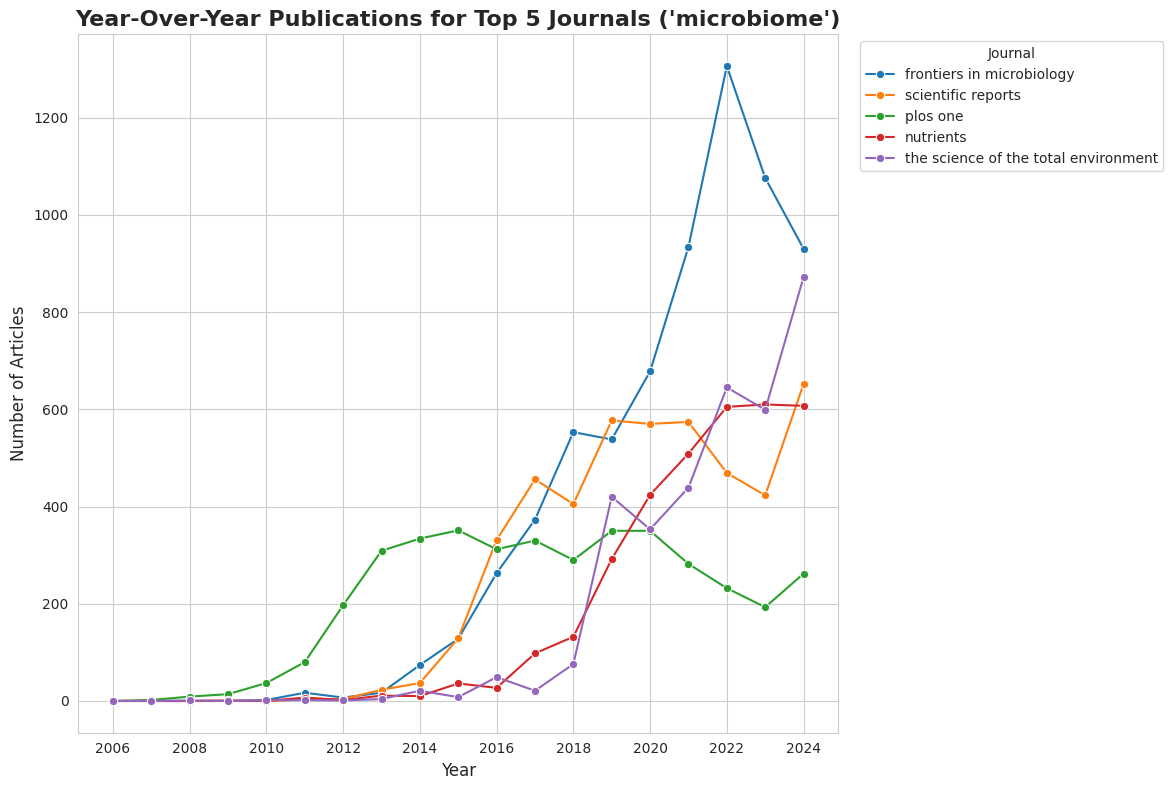

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set a visually appealing style for the plots
sns.set_style("whitegrid")

if 'pivot_df' not in locals() or pivot_df.empty:
    print("⚠️ Pivot table 'pivot_df' not found or is empty. Please run the previous cells first.")
else:
    # --- Prepare the Data ---
    # Find the top 5 journals based on the total number of publications across all years
    top_5_journals = pivot_df.sum(axis=1).nlargest(5).index

    # Filter the pivot table to include only these top 5 journals
    top_5_df = pivot_df.loc[top_5_journals]
    top_5_df = top_5_df[top_5_df.columns[1:-2]]

    # Transpose the DataFrame so that years are on the x-axis
    plot_data = top_5_df.T

    # --- Create the Line Graph ---
    plt.figure(figsize=(14, 8))

    # Create the line plot
    ax = sns.lineplot(data=plot_data, marker='o', dashes=False)

    # --- Customize the Plot ---
    plt.title(f"Year-Over-Year Publications for Top 5 Journals ('{SEARCH_TERM}')", fontsize=16, weight='bold')
    plt.ylabel("Number of Articles", fontsize=12)
    plt.xlabel("Year", fontsize=12)

    # Ensure x-axis ticks are integers representing the years
    ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True))
    plt.xticks(rotation=0)

    # Move the legend outside of the plot for better readability
    plt.legend(title='Journal', bbox_to_anchor=(1.02, 1), loc='upper left')

    # Adjust layout to prevent the legend from being cut off
    plt.tight_layout(rect=[0, 0, 0.85, 1]) # Adjust the rect to make space for the legend

    plt.show()

In [ ]:
# --- Authenticate to access Google Sheet ---
# This will prompt you to log in and authorize access.
auth.authenticate_user()
creds, _ = default()
gc = gspread.authorize(creds)

# --- Load the full, current dataset from Google Sheets ---
print("--- Loading data from Google Sheet ---")

# --- Open the spreadsheet and the specific sheet by name ---
spreadsheet_url = 'https://docs.google.com/spreadsheets/d/1tBjpV_GoXIjx4_3o73Qml0h-BzFBZTD5bc3QHx1l1_4'
spreadsheet = gc.open_by_url(spreadsheet_url)
worksheet = spreadsheet.worksheet("Main Data Sheet")

# --- Manually read the data to handle the header on the second row ---
all_values = worksheet.get_all_values()

# The header is the second row (index 1), and the data starts from the third row (index 2)
header = all_values[1]
data_rows = all_values[2:2349]

# --- Convert the lists to a pandas DataFrame --
main_data_sheet = pd.DataFrame(data_rows, columns=header)

# Clean up the DataFrame: remove rows where 'AccessionCode' is empty
# main_data_sheet = main_data_sheet[main_data_sheet['AccessionCode'] != ''].copy()
print(f"Loaded {len(main_data_sheet)} total records from Google Sheet.")

print("\n--- Successfully loaded data from Google Sheet ---")

# Display the first few rows of the loaded data
DataTable(main_data_sheet.head())

--- Loading data from Google Sheet ---
Loaded 2347 total records from Google Sheet.

--- Successfully loaded data from Google Sheet ---


,Author1Author2name (LastName1LastName2),Has someone done this study?,YourName,Host,Environment,StudyLink,StudyTitle,Year,Country,Disease,...,attr_env_medium,attr_isolate,attr_sex,Calculated Country,disease_name,classification_confidence,classification_reasoning,icd11_code,icd11_description,icd11_search_confidence
0,ZhangLiu2020,you're good!,SamuelDegregori,human,Oral,https://pmc.ncbi.nlm.nih.gov/articles/pmid/320...,The Oral Microbiota May Have Influence on Oral...,2020,China,,...,,,,China,Oral cancer,high,"The title, abstract, and methods section expli...",2B6E,Malignant neoplasms of other or ill-defined si...,high
1,Lev-SagieGoldman-Wohl2019,you're good!,EmilySong,human,Vaginal,https://www.nature.com/articles/s41591-019-060...,Vaginal microbiome transplantation in women wi...,2019,Israel,,...,,,,,Bacterial vaginosis,high,The title and abstract explicitly state that t...,,,
2,BaldiBraat2024,you're good!,SolanaCallaway,human,Gut,https://pubmed.ncbi.nlm.nih.gov/39367018/,Effects of iron supplements and iron-containin...,2024,Bangladesh,,...,,,,Bangladesh,Anemia,high,The abstract explicitly states that anemia is ...,,Anaemias or other erythrocyte disorders,
3,HosangCanals2022,you're good!,VictoriaXu,human,Pulmonary,https://www.nature.com/articles/s41586-022-044...,The lung microbiome regulates brain autoimmunity,2022,Germany,,...,,,,Germany,Multiple sclerosis,high,The abstract explicitly states that the study ...,8A40,Multiple sclerosis,
4,XiaoCai2022,you're good!,AnjaliVinodh,human,Pulmonary,https://pmc.ncbi.nlm.nih.gov/articles/PMC88654...,Insights into the Unique Lung Microbiota Profi...,2022,China,,...,BAL; Swab,,,China,Multiple sclerosis,high,The abstract explicitly states that the resear...,8A40,Multiple sclerosis,high


In [ ]:
def get_pubmed_details_by_pmid(pmid, api_key):
    """Fetches details for a single PMID and extracts journal, year, DOI, ISSN."""
    if not pmid:
        return None

    if api_key:
        params = {
            'db': 'pubmed', 'id': pmid, 'rettype': 'abstract', 'retmode': 'xml',
            'tool': 'colab_notebook', 'api_key': api_key
        }
    else:
        params = {
            'db': 'pubmed', 'id': pmid, 'rettype': 'abstract', 'retmode': 'xml',
            'tool': 'colab_notebook', 'email': YOUR_EMAIL
        }

    response = make_api_request(f"{BASE_URL}efetch.fcgi", params)

    if response:
        root = ET.fromstring(response.text)
        article = root.find('.//PubmedArticle')
        if article:
            year_node = article.find('.//PubDate/Year')
            journal_node = article.find('.//Journal/Title')
            pmid_node = article.find('.//PMID')
            issn_node = article.find('.//Journal/ISSN')
            doi_node = article.find('.//ArticleIdList/ArticleId[@IdType="doi"]')

            pub_year = int(year_node.text.strip()) if year_node is not None and year_node.text else None
            journal_title = journal_node.text.strip() if journal_node is not None and journal_node.text else None
            retrieved_pmid = pmid_node.text.strip() if pmid_node is not None and pmid_node.text else None
            issn = issn_node.text.strip() if issn_node is not None and issn_node.text else None
            retrieved_doi = doi_node.text.strip() if doi_node is not None and doi_node.text else None

            if pub_year and journal_title: # Must have at least these
                 return {
                    'journal': journal_title,
                    'year': pub_year,
                    'pmid': retrieved_pmid,
                    'issn': issn,
                    'doi': retrieved_doi
                }
    return None

def get_crossref_metadata(doi, user_agent):
    """Fetches journal title, publication year, and ISSN for a given DOI from CrossRef."""
    url = f"{CROSSREF_BASE_URL}{doi}"
    headers = {'User-Agent': user_agent}
    for attempt in range(CROSSREF_RETRIES):
        try:
            response = requests.get(url, headers=headers, timeout=10)
            response.raise_for_status()
            data = response.json()
            message = data.get('message', {})

            journal_title = None
            # Check container-title first
            container_titles = message.get('container-title', [])
            if container_titles and len(container_titles) > 0:
                journal_title = container_titles[0]

            # If not found, check short-container-title
            if journal_title is None:
                short_container_titles = message.get('short-container-title', [])
                if short_container_titles and len(short_container_titles) > 0:
                    journal_title = short_container_titles[0]

            # If still not found, check main title (this is often the article title, not journal)
            # Use with caution, as it might pick up article title instead of journal.
            # However, for preprints like the one in your example, 'title' might be the only
            # meaningful "journal-like" string available if it's a "working paper series" title etc.
            if journal_title is None:
                titles = message.get('title', [])
                if titles and len(titles) > 0:
                    journal_title = titles[0]

            pub_year = None
            issued_date_parts = message.get('issued', {}).get('date-parts')
            # print(f"Issued date parts: {issued_date_parts}") # Keep for debugging if needed
            if issued_date_parts and issued_date_parts[0] and isinstance(issued_date_parts[0], list) and len(issued_date_parts[0]) > 0:
                pub_year = issued_date_parts[0][0]
            # Additional check if 'posted' or 'accepted' dates are more suitable for preprints
            elif message.get('posted', {}).get('date-parts') and message['posted']['date-parts'][0] and isinstance(message['posted']['date-parts'][0], list) and len(message['posted']['date-parts'][0]) > 0:
                pub_year = message['posted']['date-parts'][0][0]
            elif message.get('accepted', {}).get('date-parts') and message['accepted']['date-parts'][0] and isinstance(message['accepted']['date-parts'][0], list) and len(message['accepted']['date-parts'][0]) > 0:
                pub_year = message['accepted']['date-parts'][0][0]


            issn_list = message.get('ISSN', [])
            # print(f"ISSN list: {issn_list}") # Keep for debugging if needed
            issn = issn_list[0] if issn_list and len(issn_list) > 0 else None # Get the first ISSN if available

            return journal_title, pub_year, issn

        except requests.exceptions.RequestException as e:
            print(f"CrossRef request failed for DOI {doi} (attempt {attempt + 1}/{CROSSREF_RETRIES}): {e}")
            if attempt < CROSSREF_RETRIES - 1:
                time.sleep(CROSSREF_RETRY_DELAY)
            else:
                print(f"Max retries reached for DOI {doi}.")
                return None, None, None
        except json.JSONDecodeError:
            print(f"Failed to decode JSON for DOI {doi}. Skipping.")
            return None, None, None
        except IndexError:
            print(f"Unexpected date-parts structure for DOI {doi}. Skipping.")
            print(data)
            return None, None, None
        except Exception as e:
            print(f"An unexpected error occurred for DOI {doi}: {e}. Skipping.")
            return None, None, None

def search_pubmed_by_aid_or_title(identifier_type, identifier_value, api_key, retmax=5):
    """
    Searches PubMed using either AID (like DOI) or Title.
    Returns a list of PMIDs found.
    """
    if not identifier_value:
        return []

    params = {
        'db': 'pubmed',
        'retmax': retmax,
        'retmode': 'xml',
        'tool': 'colab_notebook',
    }
    if api_key:
        params['api_key'] = api_key
    else:
        params['email'] = YOUR_EMAIL

    search_term_val = str(identifier_value).strip()

    if identifier_type == 'aid':
        # Search by identifier [aid]
        params['term'] = f"{search_term_val}[aid]"
    elif identifier_type == 'title':
        # Search by title, without quotes around the title as per observation
        params['term'] = f"{search_term_val}[Title]"
    else:
        print(f"Error: Unknown identifier_type '{identifier_type}'.")
        return []

    response = make_api_request(f"{BASE_URL}esearch.fcgi", params)
    pmids = []
    if response:
        root = ET.fromstring(response.text)
        pmids = [id_node.text for id_node in root.findall('.//IdList/Id')]
    return pmids

In [ ]:
# Google Sheet Processing Logic ---
gs_processed_articles = []

for index, row in tqdm(main_data_sheet.iterrows(), total=len(main_data_sheet), desc="Processing Google Sheet Articles"):
    study_title_raw = row.get('StudyTitle')
    google_sheet_doi_raw = row.get('DOI')

    if isinstance(study_title_raw, pd.Series):
        # If it's still a Series (e.g., if Google Sheet had duplicate column names),
        # take the first element or handle as appropriate.
        study_title = study_title_raw.iloc[0] # Take the first value if it's a Series

    # Ensure study_title is a string and not empty after stripping
    study_title = str(study_title_raw).strip()
    google_sheet_doi = str(google_sheet_doi_raw).strip() if pd.notna(google_sheet_doi_raw) else ''

    if not study_title and not google_sheet_doi:
        print(f"Skipping row {index}: No StudyTitle or DOI provided.")
        continue # Skip if both are missing

    found_article_info = None # This will hold the successfully retrieved info

    # Normalize Google Sheet DOI for consistent comparison (remove common prefixes)
    gs_doi_normalized = google_sheet_doi.lower().replace('https://doi.org/', '').strip()

    # --- Attempt 1: PubMed Search by DOI [aid] ---
    if google_sheet_doi:
        pmids_from_aid_search = search_pubmed_by_aid_or_title('aid', google_sheet_doi, API_KEY)
        for pmid in pmids_from_aid_search:
            details = get_pubmed_details_by_pmid(pmid, API_KEY)
            if details:
                retrieved_doi_normalized = details['doi'].lower().replace('https://doi.org/', '').strip() if details['doi'] else ''
                if gs_doi_normalized and retrieved_doi_normalized == gs_doi_normalized:
                    found_article_info = {
                        'Year': details['year'],
                        'Journal': details['journal'],
                        'PMID': details['pmid'],
                        'ISSN': details['issn'],
                        'DOI_Retrieved': details['doi'],
                        'Source': 'PubMed_AID_Match'
                    }
                    break # Found a definitive match, stop checking other PMIDs for this DOI
        if found_article_info:
            # print(f"Row {index}: Matched via PubMed AID.")
            pass # Matched, no need for further searches

    # --- Attempt 2: PubMed Search by Title (if AID search failed or no definitive DOI match) ---
    if not found_article_info and study_title:
        pmids_from_title_search = search_pubmed_by_aid_or_title('title', study_title, API_KEY)

        # If there's a Google Sheet DOI, try to validate title search results with it
        potential_pubmed_matches = []
        for pmid in pmids_from_title_search:
            details = get_pubmed_details_by_pmid(pmid, API_KEY)
            if details:
                if google_sheet_doi: # If we have a DOI to validate against
                    retrieved_doi_normalized = details['doi'].lower().replace('https://doi.org/', '').strip() if details['doi'] else ''
                    if gs_doi_normalized and retrieved_doi_normalized == gs_doi_normalized:
                        potential_pubmed_matches.append(details)
                else: # If no DOI in GS, just consider the title match as potential
                    potential_pubmed_matches.append(details)

        if len(potential_pubmed_matches) == 1:
            found_article_info = {
                'Year': potential_pubmed_matches[0]['year'],
                'Journal': potential_pubmed_matches[0]['journal'],
                'PMID': potential_pubmed_matches[0]['pmid'],
                'ISSN': potential_pubmed_matches[0]['issn'],
                'DOI_Retrieved': potential_pubmed_matches[0]['doi'],
                'Source': 'PubMed_Title_Match_Validated' if google_sheet_doi else 'PubMed_Title_Match_No_DOI_Validation'
            }
            # print(f"Row {index}: Matched via PubMed Title.")
        elif len(potential_pubmed_matches) > 1 and google_sheet_doi:
            # Ambiguous title match, but at least one matched DOI, take the first definitive one
            # This case means multiple papers might have very similar titles but only one matched DOI
            print(f"Warning: Multiple PubMed title matches for '{study_title}', taking first validated by DOI '{google_sheet_doi}'.")
            found_article_info = {
                'Year': potential_pubmed_matches[0]['year'],
                'Journal': potential_pubmed_matches[0]['journal'],
                'PMID': potential_pubmed_matches[0]['pmid'],
                'ISSN': potential_pubmed_matches[0]['issn'],
                'DOI_Retrieved': potential_pubmed_matches[0]['doi'],
                'Source': 'PubMed_Title_Match_Ambiguous_DOI_Validated'
            }
        elif len(potential_pubmed_matches) > 0 and not google_sheet_doi:
             # Multiple title matches without DOI for validation. Can't be definitive.
             # You might choose to skip these or take the first one with a warning.
             # For now, we'll treat it as not definitive enough for PubMed.
             # Or you could take the first if you expect titles to be unique enough.
             print(f"Warning: Multiple PubMed title matches for '{study_title}' with no DOI for validation. Skipping PubMed for this row.")


    # --- Attempt 3: CrossRef Fallback (if no definitive PubMed match) ---
    if not found_article_info and google_sheet_doi:
        journal_cr, year_cr, issn_cr = get_crossref_metadata(google_sheet_doi, USER_AGENT)
        if journal_cr and year_cr:
            found_article_info = {
                'Year': year_cr,
                'Journal': journal_cr,
                'PMID': None,
                'ISSN': issn_cr,
                'DOI_Retrieved': google_sheet_doi,
                'Source': 'CrossRef_Fallback'
            }
            # print(f"Row {index}: Matched via CrossRef.")
        else:
            pass # Couldn't find info even with CrossRef

    if found_article_info and found_article_info.get('Journal') and found_article_info.get('Year'):
        try:
            article_year = int(found_article_info['Year'])
            if START_YEAR <= article_year <= END_YEAR:
                gs_processed_articles.append({
                    'Original_Title': study_title_raw, # Keep original title
                    'Original_DOI': google_sheet_doi_raw, # Keep original DOI
                    'Year': article_year,
                    'Journal': found_article_info['Journal'],
                    'PMID': found_article_info['PMID'],
                    'ISSN': found_article_info['ISSN'],
                    'DOI_Retrieved': found_article_info['DOI_Retrieved'],
                    'Source': found_article_info['Source']
                })
        except ValueError:
            print(f"Skipping row {index} due to invalid year: {found_article_info['Year']}")
    else:
        print(f"Row {index}: No definitive article info found or year out of range.")


Processing Google Sheet Articles:   0%|          | 0/2347 [00:00<?, ?it/s]

Row 162: No definitive article info found or year out of range.
Row 171: No definitive article info found or year out of range.
Row 1183: No definitive article info found or year out of range.
Row 1326: No definitive article info found or year out of range.
Row 1384: No definitive article info found or year out of range.
Row 1386: No definitive article info found or year out of range.
Row 1394: No definitive article info found or year out of range.
Row 1395: No definitive article info found or year out of range.
Row 1461: No definitive article info found or year out of range.
Row 1462: No definitive article info found or year out of range.
Row 1463: No definitive article info found or year out of range.
Row 1731: No definitive article info found or year out of range.
Row 1803: No definitive article info found or year out of range.
Row 1806: No definitive article info found or year out of range.
Row 1855: No definitive article info found or year out of range.
Row 1927: No definitive art

In [ ]:

# Process the collected Google Sheet data
if gs_processed_articles:
    gs_results_df = pd.DataFrame(gs_processed_articles)
    gs_results_df['Standardized_Journal'] = gs_results_df['Journal'].apply(standardize_journal_name)

    print("\n--- Google Sheet - Raw Processed Data (First 5) ---")
    print(f"Total articles processed from Google Sheet with details: {len(gs_results_df)}")
    print(f"Total unique journals found from Google Sheet processing: {gs_results_df['Journal'].nunique()}")
    display(gs_results_df.head())

    # Create the pivot table FIRST
    gs_pivot_df = gs_results_df.pivot_table(
        index='Standardized_Journal',
        columns='Year',
        aggfunc='size',
        fill_value=0
    )

    # Check if gs_pivot_df is not empty before attempting to sort
    if not gs_pivot_df.empty:
        # Check if END_YEAR is actually a column in gs_pivot_df
        sort_column = END_YEAR
        if END_YEAR not in gs_pivot_df.columns:
            # If END_YEAR is not a column (e.g., no data for that year),
            # try to sort by the last available year column, or total sum.
            if not gs_pivot_df.columns.empty:
                 sort_column = gs_pivot_df.columns[-1]
            else:
                 # Fallback if no year columns are present (very unlikely if data exists)
                 sort_column = None # Will then sort by index, or require another strategy

        if sort_column is not None:
             gs_pivot_df = gs_pivot_df.sort_values(by=sort_column, ascending=False)
        else:
             print("Warning: Could not determine a column to sort by for Google Sheet pivot table. Sorting by index.")
             gs_pivot_df = gs_pivot_df.sort_index(ascending=False) # Or sort by index if no columns.


    print("\n--- Google Sheet - Journal Counts by Year (Pivot Table - Standardized Names) ---")
    display(gs_pivot_df.head(20))

    gs_output_filename = f'google_sheet_processed_counts_{SEARCH_TERM}_{START_YEAR}-{END_YEAR}.csv'
    gs_pivot_df.to_csv(gs_output_filename)
    print(f"\nResults from Google Sheet processing saved to '{gs_output_filename}'.")

else:
    print("No data was collected from Google Sheet DOIs after processing. Cannot generate results.")


--- Google Sheet - Raw Processed Data (First 5) ---
Total articles processed from Google Sheet with details: 2313
Total unique journals found from Google Sheet processing: 652


,Original_Title,Original_DOI,Year,Journal,PMID,ISSN,DOI_Retrieved,Source,Standardized_Journal
0,StudyTitle The Oral Microbiota May Have Inf...,10.3389/fcimb.2019.00476,2019,Frontiers in cellular and infection microbiology,32010645,2235-2988,10.3389/fcimb.2019.00476,PubMed_AID_Match,frontiers in cellular and infection microbiology
1,StudyTitle Vaginal microbiome transplantati...,10.1038/s41591-019-0600-6,2019,Nature medicine,31591599,1546-170X,10.1038/s41591-019-0600-6,PubMed_AID_Match,nature medicine
2,StudyTitle Effects of iron supplements and ...,10.1038/s41467-024-53013-x,2024,Nature communications,39367018,2041-1723,10.1038/s41467-024-53013-x,PubMed_AID_Match,nature communications
3,StudyTitle The lung microbiome regulates br...,10.1038/s41586-022-04427-4,2022,Nature,35197636,1476-4687,10.1038/s41586-022-04427-4,PubMed_AID_Match,nature
4,StudyTitle Insights into the Unique Lung Mi...,10.1128/spectrum.01901-21,2022,Microbiology spectrum,35196800,2165-0497,10.1128/spectrum.01901-21,PubMed_AID_Match,microbiology spectrum



--- Google Sheet - Journal Counts by Year (Pivot Table - Standardized Names) ---


Year,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,...,2016,2017,2018,2019,2020,2021,2022,2023,2024,2025
Standardized_Journal,,,,,,,,,,,,,,,,,,,,,
npj biofilms and microbiomes,0,0,0,0,0,0,0,0,0,0,...,0,1,0,2,2,6,2,2,8,32
scientific reports,0,0,0,0,0,0,0,0,0,0,...,5,3,9,23,14,16,12,7,25,22
nature,0,1,0,0,1,1,0,4,1,4,...,2,1,4,5,4,5,7,4,8,16
nature communications,0,0,0,0,0,0,0,0,0,0,...,0,2,0,3,4,4,4,3,11,14
microbiology spectrum,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,3,9,14,9,8
international journal of molecular sciences,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,5,5,6,11,7
gut microbes,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,2,5,7,12,14,7
microbiome,0,0,0,0,0,0,0,0,0,1,...,4,11,6,8,4,12,11,9,11,7
bmc oral health,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,3,6



Results from Google Sheet processing saved to 'google_sheet_processed_counts_microbiome_2005-2025.csv'.


In [ ]:
if 'pivot_df' in locals() and not pivot_df.empty and 'gs_pivot_df' in locals() and not gs_pivot_df.empty:
    print("\n--- Performing Statistical Comparison (PubMed vs. Google Sheet) ---")

    pubmed_total_counts = pivot_df.sum(axis=1)
    gs_total_counts = gs_pivot_df.sum(axis=1)

    common_journals = pubmed_total_counts.index.intersection(gs_total_counts.index)

    if not common_journals.empty:
        pubmed_common_counts = pubmed_total_counts.loc[common_journals].fillna(0)
        gs_common_counts = gs_total_counts.loc[common_journals].fillna(0)

        valid_journals_for_chi2 = gs_common_counts[gs_common_counts > 0].index
        valid_journals_for_chi2 = valid_journals_for_chi2.intersection(pubmed_common_counts[pubmed_common_counts > 0].index)

        if len(valid_journals_for_chi2) < 2:
            print("Not enough common journals with observations in both datasets for a meaningful Chi-squared test.")
        else:
            pubmed_for_chi2 = pubmed_common_counts.loc[valid_journals_for_chi2]
            gs_for_chi2 = gs_common_counts.loc[valid_journals_for_chi2]

            pubmed_proportions = pubmed_for_chi2 / pubmed_for_chi2.sum()
            total_gs_articles_for_chi2 = gs_for_chi2.sum()
            expected_gs_counts = pubmed_proportions * total_gs_articles_for_chi2

            min_expected = expected_gs_counts.min()
            if min_expected < 1:
                print(f"Warning: Some expected counts are very small (min={min_expected:.2f}). This may affect Chi-squared test validity.")
                print("Consider combining categories or using Fisher's exact test for small samples.")

            chi2_stat, p_value = chisquare(f_obs=gs_for_chi2, f_exp=expected_gs_counts)

            print(f"\nChi-squared statistic: {chi2_stat:.4f}")
            print(f"P-value: {p_value:.4f}")

            alpha = 0.05

            if p_value < alpha:
                print(f"\nSince the p-value ({p_value:.4f}) is less than the significance level ({alpha}),")
                print("we reject the null hypothesis.")
                print("This suggests that the distribution of journals in the Google Sheet sample is significantly different")
                print("from what would be expected based on the PubMed distribution. The Google Sheet sample may be biased.")
            else:
                print(f"\nSince the p-value ({p_value:.4f}) is greater than the significance level ({alpha}),")
                print("we fail to reject the null hypothesis.")
                print("This suggests that there is no statistically significant difference in the journal distribution")
                print("between the Google Sheet sample and the PubMed results for the common journals. The Google Sheet sample")
                print("appears to be consistent with a random sample from the PubMed population based on journal distribution.")
    else:
        print("No common journals found between PubMed and Google Sheet data for statistical comparison.")
else:
    print("\nSkipping statistical comparison: Either PubMed or Google Sheet data (or both) are not available or are empty.")



--- Performing Statistical Comparison (PubMed vs. Google Sheet) ---
Consider combining categories or using Fisher's exact test for small samples.

Chi-squared statistic: 4406.5552
P-value: 0.0000

Since the p-value (0.0000) is less than the significance level (0.05),
we reject the null hypothesis.
This suggests that the distribution of journals in the Google Sheet sample is significantly different
from what would be expected based on the PubMed distribution. The Google Sheet sample may be biased.



--- Generating Top Journals Proportion Bar Chart ---


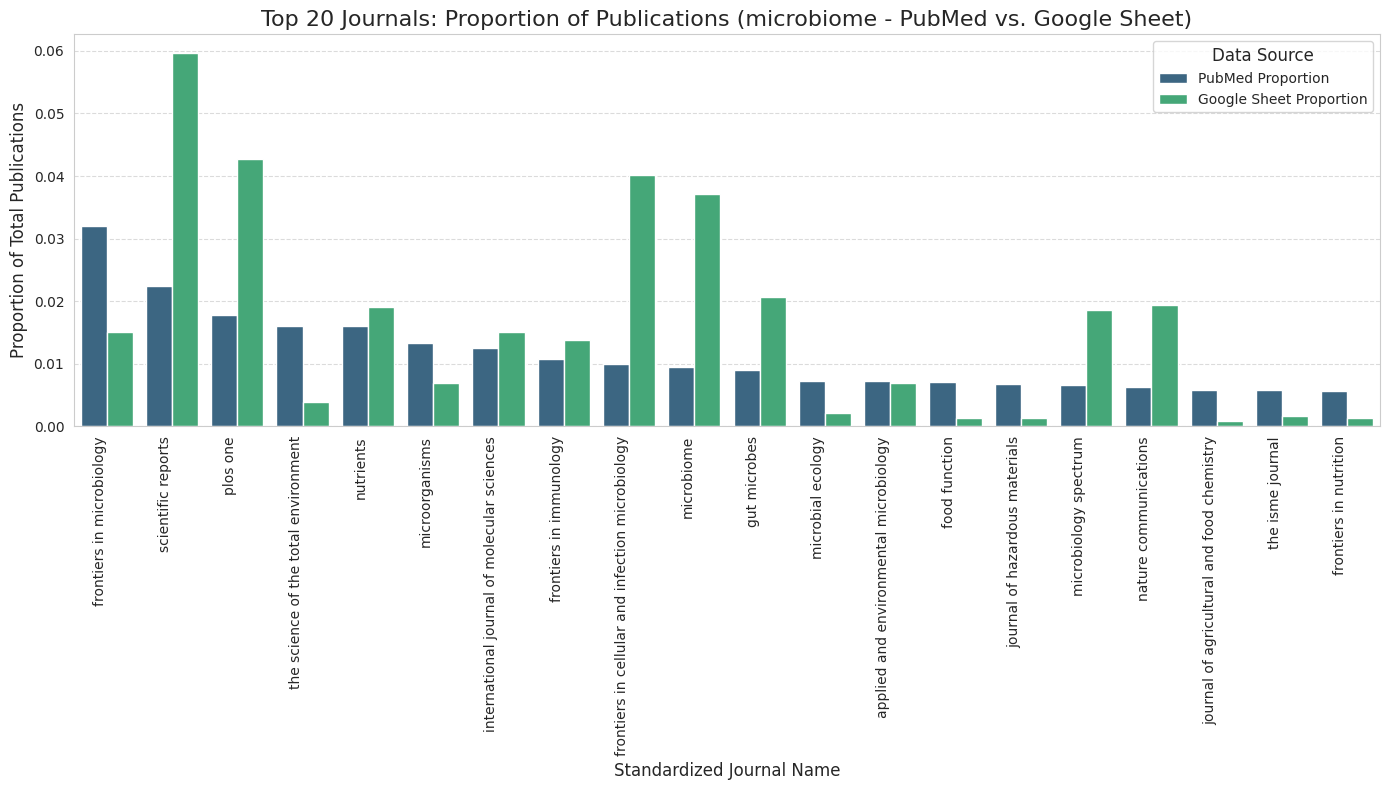


--- Generating Proportion Scatter Plot ---


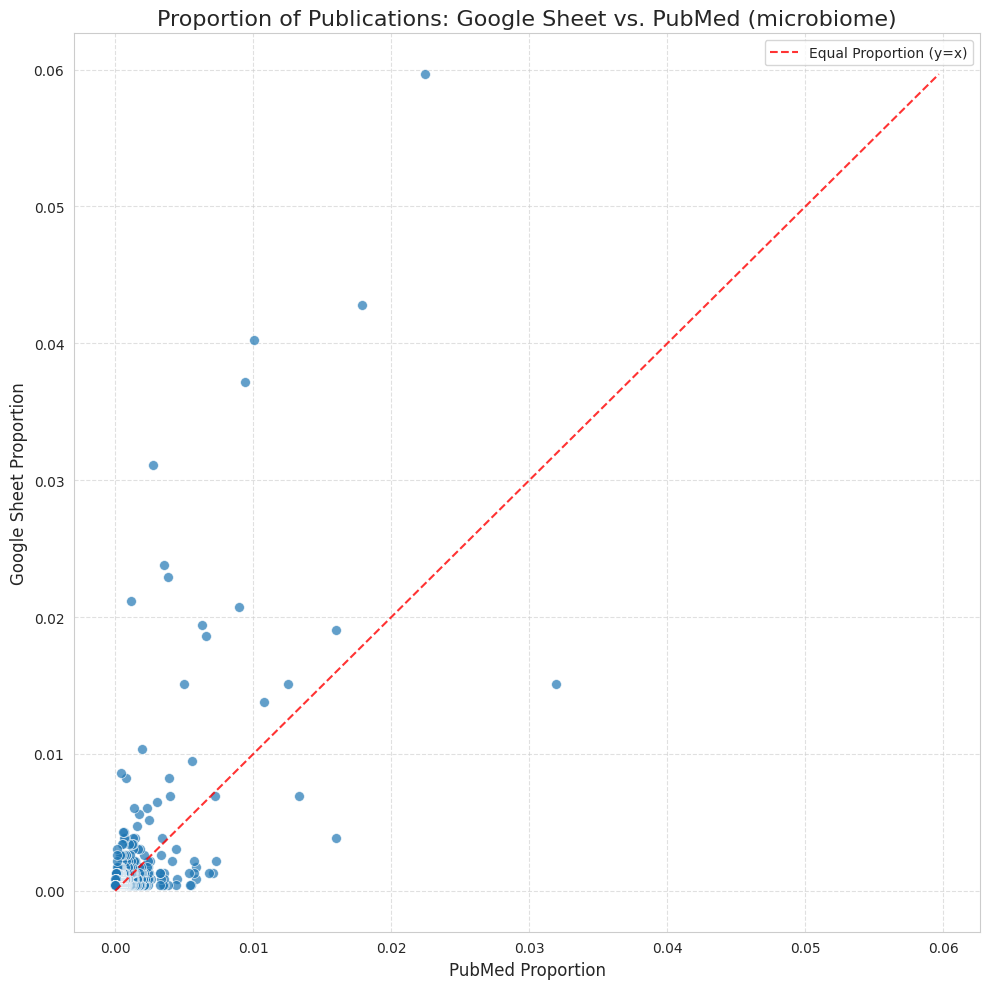


--- Generating Heatmaps for Top Journals Over Years ---


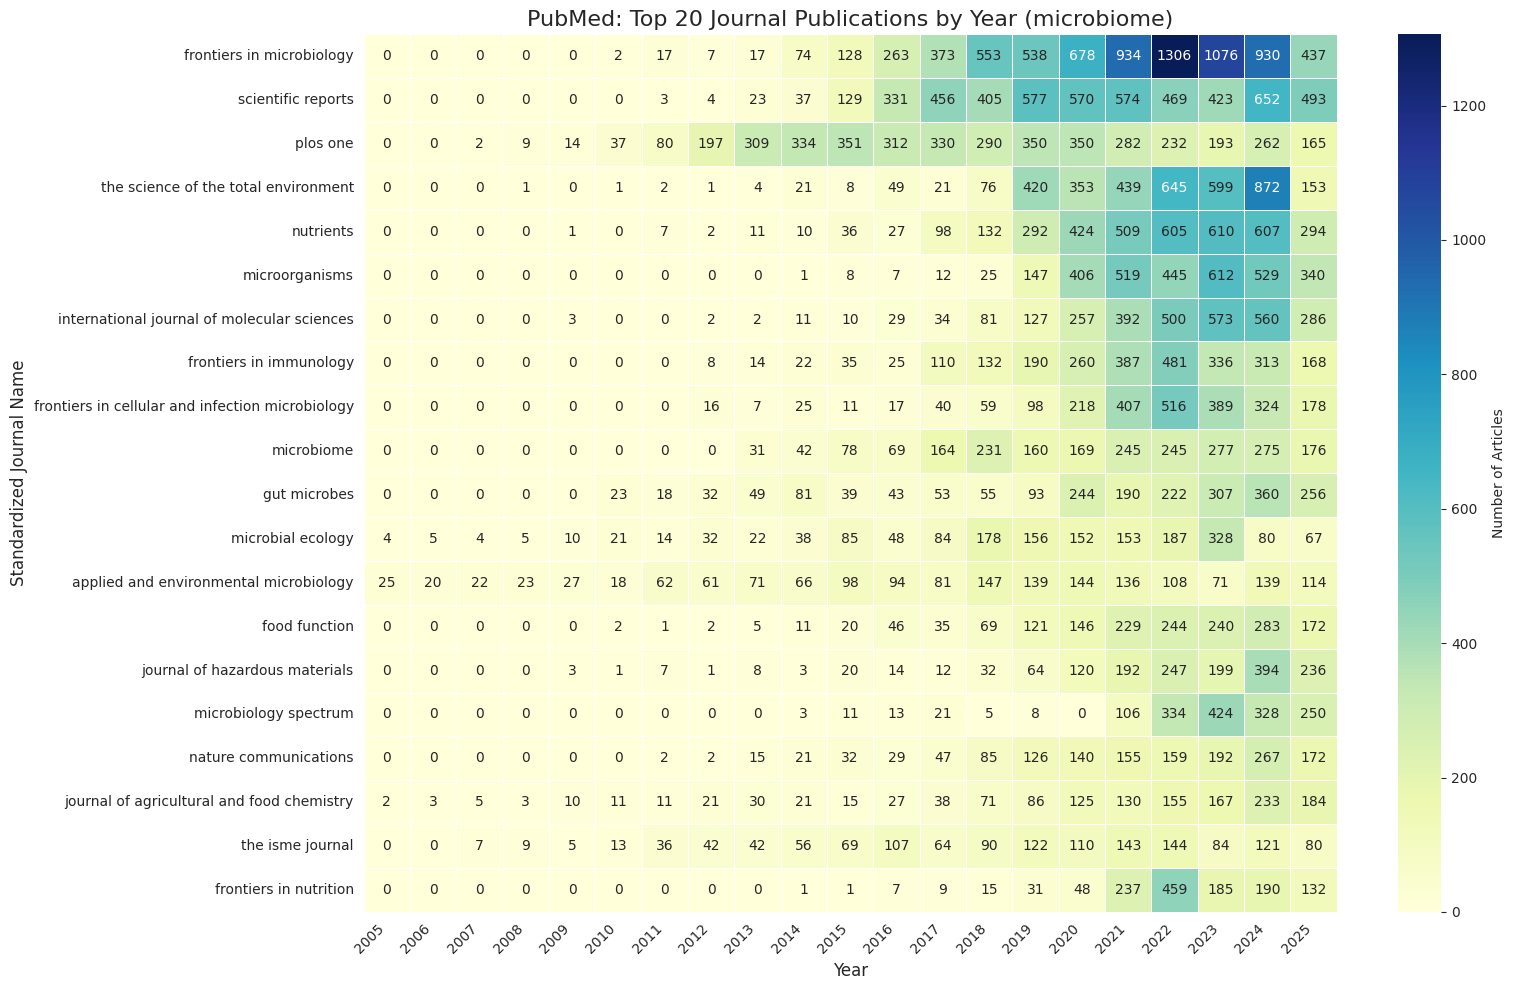

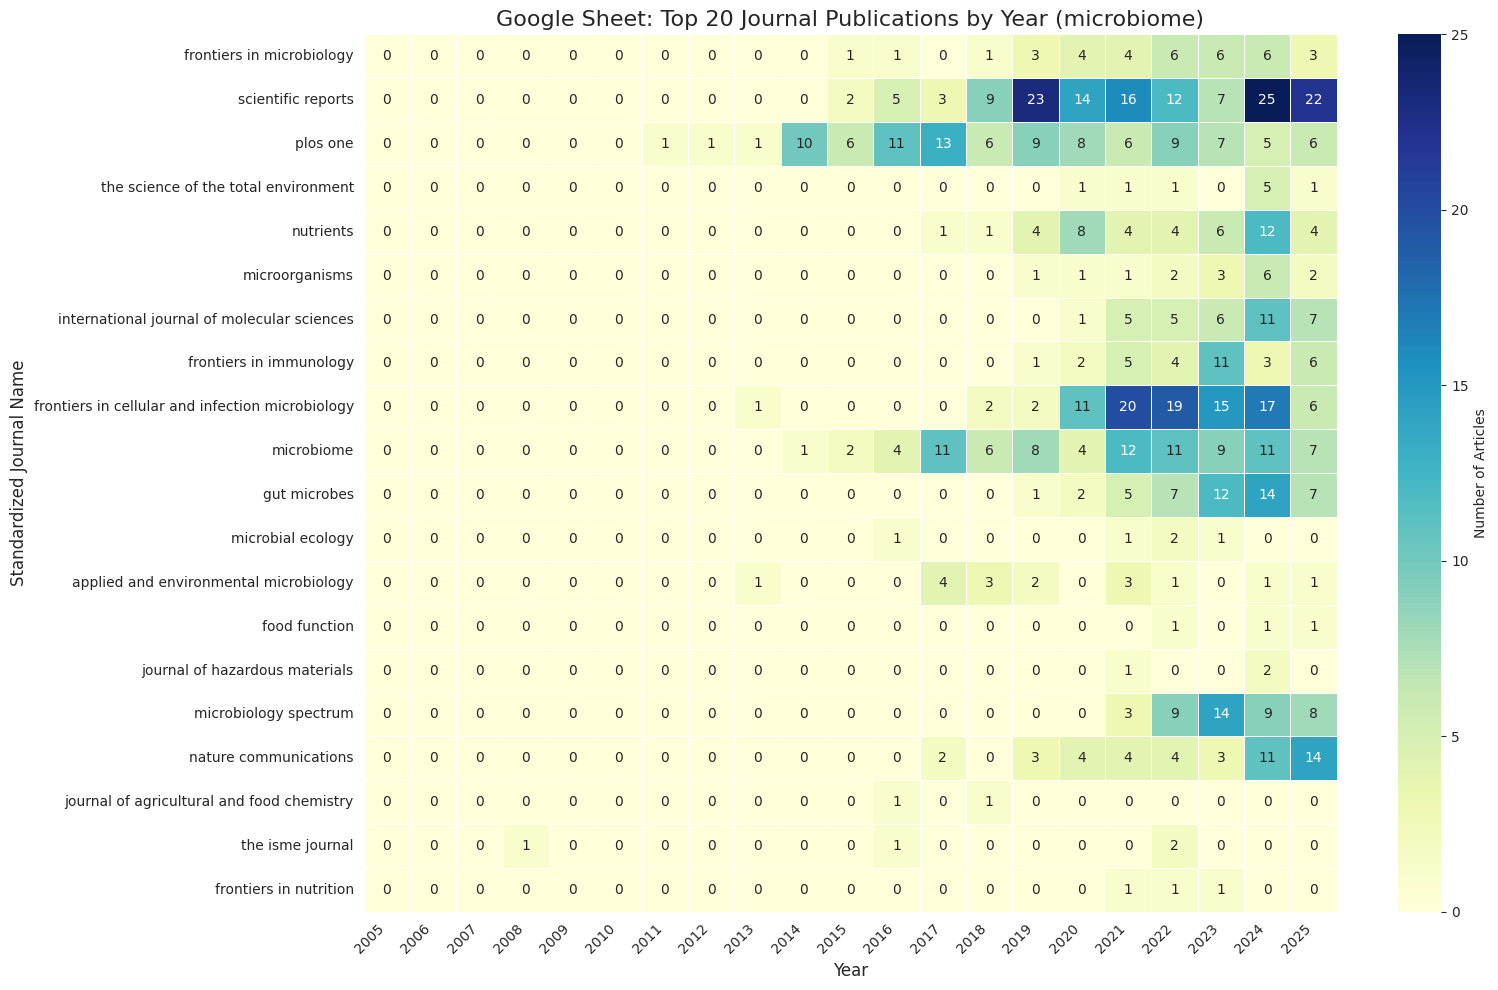

In [ ]:
# --- 2. Prepare Data for Visualizations (Proportion Differences) ---

# Calculate total articles for proportion calculation from the summed Series
total_pubmed_articles = pubmed_total_counts.sum()
total_gs_articles = gs_total_counts.sum()

# Calculate proportions for all common journals
if total_pubmed_articles == 0:
    pubmed_proportions_all = pd.Series(0, index=common_journals)
else:
    pubmed_proportions_all = pubmed_total_counts.loc[common_journals] / total_pubmed_articles

if total_gs_articles == 0:
    gs_proportions_all = pd.Series(0, index=common_journals)
else:
    gs_proportions_all = gs_total_counts.loc[common_journals] / total_gs_articles

# Combine proportions into a single DataFrame
comparison_proportions = pd.DataFrame({
    'PubMed Proportion': pubmed_proportions_all,
    'Google Sheet Proportion': gs_proportions_all
}).fillna(0) # Fill NaN with 0 for journals only in one set of common

# Sort by PubMed proportion to get top journals for visualization
comparison_proportions = comparison_proportions.sort_values(by='PubMed Proportion', ascending=False)


# --- 3. Visualization 1: Top Journals Proportion Bar Chart ---
print("\n--- Generating Top Journals Proportion Bar Chart ---")
top_n = 20 # Number of top journals to display
top_journals_for_plot = comparison_proportions.head(top_n)

if not top_journals_for_plot.empty:
    # Melt the DataFrame for seaborn.barplot
    plot_df_melted = top_journals_for_plot.reset_index().melt(id_vars='Standardized_Journal', var_name='Source', value_name='Proportion')

    plt.figure(figsize=(14, 8))
    sns.barplot(x='Standardized_Journal', y='Proportion', hue='Source', data=plot_df_melted, palette='viridis')
    plt.title(f'Top {top_n} Journals: Proportion of Publications ({SEARCH_TERM} - PubMed vs. Google Sheet)', fontsize=16)
    plt.xlabel('Standardized Journal Name', fontsize=12)
    plt.ylabel('Proportion of Total Publications', fontsize=12)
    plt.xticks(rotation=90, ha='right', fontsize=10)
    plt.yticks(fontsize=10)
    plt.legend(title='Data Source', fontsize=10, title_fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig('top_journals_proportion_bar_chart.png', dpi=300)
    plt.show()
else:
    print("No common journals to plot for Top Journals Proportion Bar Chart.")


# --- 4. Visualization 2: Proportion Scatter Plot ---
print("\n--- Generating Proportion Scatter Plot ---")
if not comparison_proportions.empty:
    plt.figure(figsize=(10, 10))
    sns.scatterplot(x='PubMed Proportion', y='Google Sheet Proportion', data=comparison_proportions, alpha=0.7, s=50)

    max_prop = max(comparison_proportions['PubMed Proportion'].max(), comparison_proportions['Google Sheet Proportion'].max())
    plt.plot([0, max_prop], [0, max_prop], color='red', linestyle='--', label='Equal Proportion (y=x)', alpha=0.8)

    plt.title(f'Proportion of Publications: Google Sheet vs. PubMed ({SEARCH_TERM})', fontsize=16)
    plt.xlabel('PubMed Proportion', fontsize=12)
    plt.ylabel('Google Sheet Proportion', fontsize=12)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.legend(fontsize=10)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.savefig('proportions_scatter_plot.png', dpi=300)
    plt.show()
else:
    print("No common journals to plot for Proportions Scatter Plot.")


# --- 5. Visualization 3: Heatmap of Top Journals Over Years (PubMed & Google Sheet) ---
print("\n--- Generating Heatmaps for Top Journals Over Years ---")

# Ensure common years are integers for consistent indexing
# `pivot_df.columns` and `gs_pivot_df.columns` should already be integers from loading.
common_years = pivot_df.columns.intersection(gs_pivot_df.columns).astype(int)
common_years_filtered = [year for year in common_years if START_YEAR <= year <= END_YEAR]


if not common_journals.empty and common_years_filtered and not top_journals_for_plot.empty:
    # Select top N journals for the heatmap based on overall counts
    top_journals_heatmap_index = top_journals_for_plot.index

    # Get data for selected journals and common years from the *original* pivot tables.
    # Use .reindex to ensure all years in common_years_filtered are present as columns, filling missing with 0.
    pubmed_heatmap_data = pivot_df.loc[top_journals_heatmap_index, :].reindex(columns=common_years_filtered, fill_value=0)
    gs_heatmap_data = gs_pivot_df.loc[top_journals_heatmap_index, :].reindex(columns=common_years_filtered, fill_value=0)

    # Plot PubMed Heatmap
    plt.figure(figsize=(16, 10))
    sns.heatmap(pubmed_heatmap_data, annot=True, fmt='d', cmap='YlGnBu', linewidths=.5, cbar_kws={'label': 'Number of Articles'})
    plt.title(f'PubMed: Top {top_n} Journal Publications by Year ({SEARCH_TERM})', fontsize=16)
    plt.xlabel('Year', fontsize=12)
    plt.ylabel('Standardized Journal Name', fontsize=12)
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.yticks(rotation=0, fontsize=10)
    plt.tight_layout()
    plt.savefig('pubmed_heatmap.png', dpi=300)
    plt.show()

    # Plot Google Sheet Heatmap
    plt.figure(figsize=(16, 10))
    sns.heatmap(gs_heatmap_data, annot=True, fmt='d', cmap='YlGnBu', linewidths=.5, cbar_kws={'label': 'Number of Articles'})
    plt.title(f'Google Sheet: Top {top_n} Journal Publications by Year ({SEARCH_TERM})', fontsize=16)
    plt.xlabel('Year', fontsize=12)
    plt.ylabel('Standardized Journal Name', fontsize=12)
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.yticks(rotation=0, fontsize=10)
    plt.tight_layout()
    plt.savefig('google_sheet_heatmap.png', dpi=300)
    plt.show()

else:
    print("No common journals or valid years for generating heatmaps.")

In [ ]:
from scipy.stats import chi2_contingency, fisher_exact

# --- Assuming pivot_df and gs_pivot_df are already defined from previous steps ---
# For demonstration purposes, if you run this code block standalone, uncomment the following lines
# and ensure the CSV files are in your environment:
# try:
#     pivot_df = pd.read_csv('ncbi_counts_microbiome_2005-2025.csv', index_col='Standardized_Journal')
#     pivot_df.columns = pivot_df.columns.astype(int)
#     gs_pivot_df = pd.read_csv('google_sheet_processed_counts_microbiome_2005-2025.csv', index_col='Standardized_Journal')
#     gs_pivot_df.columns = gs_pivot_df.columns.astype(int)
#     print("DataFrames loaded for demonstration.")
# except FileNotFoundError:
#     print("Error: CSV files not found. Please ensure they are in the correct directory or pivot_df/gs_pivot_df are defined.")
#     exit()

# --- Prepare data for statistical comparison ---
pubmed_total_counts = pivot_df.sum(axis=1)
gs_total_counts = gs_pivot_df.sum(axis=1)

common_journals = pubmed_total_counts.index.intersection(gs_total_counts.index)

# Filter counts for only common journals and ensure integer type
pubmed_common_counts = pubmed_total_counts.loc[common_journals].fillna(0).astype(int)
gs_common_counts = gs_total_counts.loc[common_journals].fillna(0).astype(int)

# Filter for valid journals for chi-square (those with observations in GS and >0 expected in PubMed)
valid_journals_for_chi2 = gs_common_counts[gs_common_counts > 0].index
valid_journals_for_chi2 = valid_journals_for_chi2.intersection(pubmed_common_counts[pubmed_common_counts > 0].index)

if len(valid_journals_for_chi2) < 2:
    print("Not enough common journals with sufficient observations for robust statistical tests.")
    print("Skipping Chi-squared, Cramer's V, and Fisher's Exact Test calculations.")
else:
    pubmed_for_chi2 = pubmed_common_counts.loc[valid_journals_for_chi2]
    gs_for_chi2 = gs_common_counts.loc[valid_journals_for_chi2]

    # Create a contingency table for Chi-squared test of independence
    contingency_table = pd.DataFrame({
        'Google Sheet': gs_for_chi2,
        'PubMed': pubmed_for_chi2
    }).T # Transpose to have datasets as rows

    print("\n--- Statistical Analysis: Chi-squared and Cramer's V ---")
    print("Contingency Table (first 5 journals):")
    print(contingency_table.head())

    # Perform Chi-squared test
    chi2, p_value_chi2, dof, expected = chi2_contingency(contingency_table)

    # Calculate Cramer's V (Effect Size)
    N = contingency_table.sum().sum()
    min_dim = min(contingency_table.shape) - 1 # For a 2xN table, min_dim = 1 if N > 1

    cramers_v = np.sqrt(chi2 / (N * min_dim)) if min_dim > 0 else np.nan

    print(f"\nChi-squared statistic: {chi2:.4f}")
    print(f"P-value (Chi-squared): {p_value_chi2:.4f}")
    print(f"Degrees of Freedom: {dof}")
    print(f"Cramer's V (Effect Size): {cramers_v:.4f}")

    alpha = 0.05
    if p_value_chi2 < alpha:
        print(f"\nConclusion (Chi-squared): Since the p-value ({p_value_chi2:.4f}) is less than the significance level ({alpha}),")
        print("we reject the null hypothesis. This suggests a statistically significant difference in journal distribution.")
    else:
        print(f"\nConclusion (Chi-squared): Since the p-value ({p_value_chi2:.4f}) is greater than the significance level ({alpha}),")
        print("we fail to reject the null hypothesis. No statistically significant difference in journal distribution.")

    print("\n--- Interpretation of Cramer's V ---")
    if not np.isnan(cramers_v):
        if cramers_v < 0.1:
            print(f"Cramer's V of {cramers_v:.4f} indicates a negligible association between the data source and journal distribution.")
        elif cramers_v < 0.2:
            print(f"Cramer's V of {cramers_v:.4f} indicates a weak association between the data source and journal distribution.")
        elif cramers_v < 0.4:
            print(f"Cramer's V of {cramers_v:.4f} indicates a moderate association between the data source and journal distribution.")
        elif cramers_v < 0.6:
            print(f"Cramer's V of {cramers_v:.4f} indicates a moderately strong association between the data source and journal distribution.")
        else:
            print(f"Cramer's V of {cramers_v:.4f} indicates a strong association between the data source and journal distribution.")
        print("This measures the practical significance of the difference, complementing the Chi-squared p-value.")
    else:
        print("Cramer's V could not be calculated (e.g., due to insufficient dimensions in the contingency table).")

    # --- Fisher's Exact Test Demonstration ---
    print("\n--- Demonstration of Fisher's Exact Test ---")
    print("Fisher's Exact Test is typically used for 2x2 tables, especially with small expected counts.")
    print("Here, we demonstrate by comparing a specific journal's representation.")

    # Pick a prominent journal for demonstration, e.g., the top journal from PubMed
    if not pubmed_for_chi2.empty:
        example_journal = pubmed_for_chi2.idxmax() # Journal with highest count in PubMed
    else:
        example_journal = common_journals[0] if not common_journals.empty else "unknown_journal" # Fallback

    if example_journal in pubmed_common_counts.index and example_journal in gs_common_counts.index:
        obs_journal_gs = gs_common_counts.loc[example_journal]
        obs_other_gs = gs_common_counts.sum() - obs_journal_gs

        obs_journal_pubmed = pubmed_common_counts.loc[example_journal]
        obs_other_pubmed = pubmed_common_counts.sum() - obs_journal_pubmed

        # Create the 2x2 contingency table for Fisher's test
        # Row 1: Counts for the example_journal (in GS, in PubMed)
        # Row 2: Counts for all other journals (in GS, in PubMed)
        fisher_table = np.array([
            [obs_journal_gs, obs_journal_pubmed],
            [obs_other_gs, obs_other_pubmed]
        ])

        print(f"\n2x2 Contingency Table for '{example_journal}':")
        print(pd.DataFrame(fisher_table,
                           index=[example_journal, 'Other Journals'],
                           columns=['Google Sheet Sample', 'PubMed Population']))

        # Perform Fisher's Exact Test
        odds_ratio, p_value_fisher = fisher_exact(fisher_table)

        print(f"\nFisher's Exact Test for '{example_journal}':")
        print(f"Odds Ratio: {odds_ratio:.4f}")
        print(f"P-value (Fisher's Exact): {p_value_fisher:.4f}")

        if p_value_fisher < alpha:
            print(f"\nConclusion (Fisher's): Since the p-value ({p_value_fisher:.4f}) is less than the significance level ({alpha}),")
            print(f"we reject the null hypothesis. This suggests a statistically significant difference in the proportion of '{example_journal}'")
            print("between the Google Sheet sample and the PubMed population.")
        else:
            print(f"\nConclusion (Fisher's): Since the p-value ({p_value_fisher:.4f}) is greater than the significance level ({alpha}),")
            print(f"we fail to reject the null hypothesis. There is no statistically significant difference in the proportion of '{example_journal}'")
            print("between the Google Sheet sample and the PubMed population.")
    else:
        print(f"Could not find '{example_journal}' in common journals for Fisher's test demonstration.")



--- Statistical Analysis: Chi-squared and Cramer's V ---
Contingency Table (first 5 journals):
Standardized_Journal  scientific reports  frontiers in microbiology  \
Google Sheet                         138                         35   
PubMed                              5146                       7333   

Standardized_Journal  international journal of biological macromolecules  \
Google Sheet                                                          1    
PubMed                                                             1249    

Standardized_Journal  microorganisms  nutrients  \
Google Sheet                      16         44   
PubMed                          3051       3665   

Standardized_Journal  international journal of molecular sciences  \
Google Sheet                                                   35   
PubMed                                                       2867   

Standardized_Journal  gut microbes  microbiology spectrum  \
Google Sheet                    48    